<IPython.core.display.Javascript object>


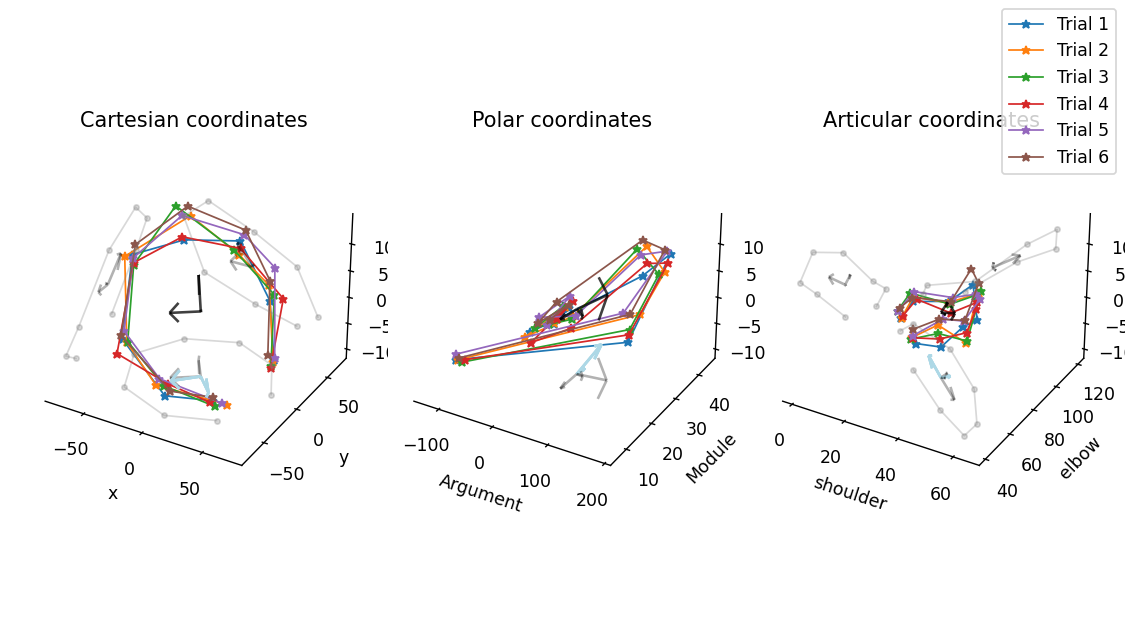

[[-0.40314476  0.5840007   0.704569  ]
 [-0.8260873  -0.56351442 -0.005592  ]
 [ 0.39376906 -0.58428989  0.70961345]] 
 
 [[1.00000000e+00 1.52179363e-08 7.45058060e-09]
 [1.52179363e-08 1.00000000e+00 1.28373958e-08]
 [7.45058060e-09 1.28373958e-08 1.00000000e+00]] 
 
 [2.01752697 1.00716191 0.03914091] 
 

[[ 0.59379408 -0.56380497  0.57404925]
 [ 0.12030308  0.76763487  0.62949494]
 [ 0.7955726   0.30473047 -0.52364452]] 
 
 [[1.00000000e+00 7.45058060e-09 1.05367121e-08]
 [7.45058060e-09 1.00000000e+00 1.05367121e-08]
 [1.05367121e-08 1.05367121e-08 1.00000000e+00]] 
 
 [2.83350065 0.19980979 0.03051935] 
 

[[ 0.70825116  0.10515456  0.6980851 ]
 [-0.02072102 -0.98532185  0.16944464]
 [ 0.70565638 -0.1344744  -0.69567644]] 
 
 [[1.00000000e+00 1.11758709e-08 1.29047841e-08]
 [1.11758709e-08 1.00000000e+00 1.05367121e-08]
 [1.29047841e-08 1.05367121e-08 1.00000000e+00]] 
 
 [1.92585658 1.02794708 0.11002613]


In [2]:
import matplotlib.pyplot as plt
import scipy.signal as sg
import scipy.ndimage as im
import numpy as np
import os 
import pywt  
from scipy.ndimage import gaussian_filter as gauss   
from scipy.signal import detrend
 
minimums = None ; aligned_cells = None ; TTargets = None
#%%% Load data
from loadDataP2 import Load
  
os.chdir("G:\\Mon Drive\\Modelling_in_neurosciences\\Projet2\\loadDataP2")
ld = Load() 
neurons = ld.dictNeurons
muscles = ld.dictMuscles
#%%% Alignement 
# maybe tester la même avec les angles 'shoang' pour voir si c'est pas mieux

minimums = {} 
plt.close("all")
for gg in range(1,len(neurons)+1):
    end = 7 # 7   
    minimums['target%s'%gg] = {} # initialisation 
    # finds the length of the shortest trial
    time_range = neurons['target%s'%gg]['trial%s'%1]["time"].flatten().size-100
    for j in range(1,7): 
        time_range = np.minimum(time_range,neurons['target%s'%gg]['trial%s'%j]["time"].flatten().size) 
    interval = time_range 
    #plt.legend()
    #fig = plt.figure()   
    for i in range(1,end): 
        time = neurons['target%s'%gg]['trial%s'%i]["time"].flatten()   
        lendiff = neurons['target%s'%gg]['trial%s'%i]["time"].flatten().size - interval
        time_range = slice(100,-100-lendiff) # crop to the length of the shortest -50 at both edges
         
        # gets varibles
        time = time[time_range]
        handypos = neurons['target%s'%gg]['trial%s'%i]["handypos"]  # smooth a bit to denoise
        elb = neurons['target%s'%gg]['trial%s'%i]["elbang"]*180/np.pi # smooth a bit to denoise
        sho = neurons['target%s'%gg]['trial%s'%i]["shoang"]*180/np.pi # smooth a bit to denoise
        
        # remove the initial position ==> to remove ?
        handypos -=  handypos[:50].mean() 
        handypos  =  handypos.flatten()[time_range]
        elb -=  elb[:50].mean() 
        elb  =  elb.flatten()[time_range]
        sho -=  sho[:50].mean() 
        sho  =  sho.flatten()[time_range]
           
        # same with x
        handxpos = neurons['target%s'%gg]['trial%s'%i]["handxpos"] 
        time = neurons['target%s'%gg]['trial%s'%i]["time"].flatten()[time_range]
        handxpos -=  handxpos[:50].mean()
        handxpos  =  handxpos.flatten()[time_range] 
        
        # find peaks + plots & store the 1st one
        vect = np.sqrt(handxpos**2+handypos**2+ 2*elb**2+ 2*sho**2)
        vect -= vect[:100].mean()
        gradmean = np.diff(vect)[:100].mean() 
        mini = np.argmin(abs(vect-vect.std()/4))
        starting_mini = mini
        indexmini = mini
        last = vect[mini]+1
        
        it = 0 ; maxiter = 1000
        update = 0 ; step = 0.6 ; lastupdate = 10 ; lastmini = mini+1 ; gradient = 0
        while True and it<=maxiter:
            it += 1
            gradient = vect[int(lastmini)]-vect[indexmini] if int(lastmini)!=indexmini else gradient
            update = step*(gradient-gradmean)*(vect[indexmini]-vect.min())
            
            if abs(update-lastupdate)<=1e-12:
                mini = indexmini
                break 
            
            last = vect[indexmini]
            lastmini = mini
            mini -= update   
            indexmini = int(mini) 
            lastupdate = update   
        ''' 
        plt.plot(time,vect,label='Trial %s'%(i+1))
        plt.plot(time[starting_mini],vect[starting_mini],'o',markersize=3.2,color='blue')
        plt.plot(time[mini],vect[mini],'ro') 
        '''       
        minimums['target%s'%gg]['trial%s'%i] = mini

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D 
plt.close('all')

def plot_pca(data,data2,num):
     
    circles = plt.figure(num=num,figsize=[9,5])
    ax11 = circles.add_subplot(131,projection='3d')
    ax12 = circles.add_subplot(133,projection='3d')
    ax13 = circles.add_subplot(132,projection='3d')
    # ax21 = circles.add_subplot(325)
    # ax22 = circles.add_subplot(326) 
    ax11.set_title('Cartesian coordinates')
    ax11.set_xlabel('x')
    ax11.set_ylabel('y')
    ax12.set_title('Articular coordinates')
    ax12.set_xlabel('shoulder')
    ax12.set_ylabel('elbow')
    ax13.set_title('Polar coordinates')
    ax13.set_xlabel('Argument')
    ax13.set_ylabel('Module')
    
    lum = 0.95
    for axi in [ax11,ax12,ax13]:
        axi.w_xaxis.set_pane_color((lum,lum,lum,0))
        axi.w_yaxis.set_pane_color((lum,lum,lum,0))
        axi.w_zaxis.set_pane_color((lum,lum,lum,0))
     
    data = np.array(data)[1:,1:]  
    data2 = np.array(data2)[1:,1:]
    data3 = np.concatenate((np.expand_dims(np.arctan2(data[:,:,0]-data[:,:,0].min(),data[:,:,1]-data[:,:,1].min())*180/np.pi,axis=-1)  # argument
                          ,np.expand_dims(np.sqrt((data[:,:,0]-data[:,:,0].min())**2 + (data[:,:,1]-data[:,:,1].min())**2),axis=-1)    # module
                          ,np.expand_dims(data[:,:,-1],axis=-1)),axis=-1)   
    
    new_data2 = data2
    shiftx = new_data2[:,:,0].mean() ; shifty = new_data2[:,:,1].mean()
    data3 = np.concatenate((np.expand_dims(np.arctan2(new_data2[:,:,0]-shiftx,new_data2[:,:,1]-shifty)*180/np.pi,axis=-1)  # argument
                          ,np.expand_dims(np.sqrt((new_data2[:,:,0]-shiftx)**2 + (new_data2[:,:,1]-shifty)**2)[::-1],axis=-1)   # module
                          ,np.expand_dims(data2[:,:,-1],axis=-1)),axis=-1)  
    # new_data = data
    # shiftx = new_data[:,:,0].mean() ; shifty = new_data[:,:,1].mean()
    # data3 = np.concatenate((np.expand_dims(np.arctan2(new_data[:,:,0]-shiftx,new_data[:,:,1]-shifty)*180/np.pi,axis=-1)  # argument
    #                       ,np.expand_dims(np.sqrt((new_data[:,:,0]-shiftx)**2 + (new_data[:,:,1]-shifty)**2),axis=-1)   # module
    #                       ,np.expand_dims(data[:,:,-1],axis=-1)),axis=-1)                  
    ax11.grid(False)
    ax12.grid(False)
    ax13.grid(False)
    for n1,n2,n3,ni in zip(data,data2,data3,np.arange(1,1+len(data))):
        ax11.plot(n1[:,0],n1[:,1],n1[:,2],'-*',markersize=5,lw=1,label='Trial %s'%ni)
        ax12.plot(n2[:,0],n2[:,1],n2[:,2],'-*',markersize=5,lw=1)
        ax13.plot(n3[:,0],n3[:,1],n3[:,2],'-*',markersize=5,lw=1)
    
    for (xxx,yyy,zzz),zdir in zip([(1,2,0),(0,2,1),(0,1,2)],['x','y','z']):
        X = data.mean(0)[:,xxx]
        Y = data.mean(0)[:,yyy]
        Z = data.mean(0)[:,zzz]
        offset = Z.min()-Z.std()/2 if zdir!='y' else Z.max()+Z.std()/2
        ax11.plot(X, Y, '-o', markersize=3,lw=1, alpha=0.3, zdir=zdir, zs=offset, color='grey')
        
        X = data2.mean(0)[:,xxx]
        Y = data2.mean(0)[:,yyy]
        Z = data2.mean(0)[:,zzz]
        offset = Z.min()-Z.std()/2 if zdir!='y' else Z.max()+Z.std()/2
        ax12.plot(X, Y, '-o', markersize=3,lw=1, alpha=0.3, zdir=zdir, zs=offset, color='grey')
        
        # X = data3.mean(0)[:,xxx]
        # Y = data3.mean(0)[:,yyy]
        # Z = data3.mean(0)[:,zzz]
        # offset = Z.min()-Z.std()/2 if zdir!='y' else Z.max()+Z.std()/2
        # ax13.plot(X, Y, '-o', markersize=3,lw=1, alpha=0.3, zdir=zdir, zs=offset, color='grey')
        
    X, Y, Z = data.mean(0).T  
    X_min = X.min()-X.std()/2
    Y_max = Y.max()+Y.std()/2
    Z_min = Z.min()-Z.std()/2
    ax11.set_xlim([X_min, X.max()+X.std()/2]) 
    ax11.set_ylim([Y.min()-Y.std()/2, Y_max]) 
    ax11.set_zlim([Z_min, Z.max()+Z.std()/2]) 
    
    X2, Y2, Z2 = data2.mean(0).T  
    X_min2 = X2.min()-X2.std()/2
    Y_max2 = Y2.max()+Y2.std()/2
    Z_min2 = Z2.min()-Z2.std()/2
    ax12.set_xlim([X_min2, X2.max()+X2.std()/2]) 
    ax12.set_ylim([Y2.min()-Y2.std()/2, Y_max2]) 
    ax12.set_zlim([Z_min2, Z2.max()+Z2.std()/2])
    
    X3, Y3, Z3 = data3.mean(0).T  
    X_min3 = X3.min()-X3.std()/2
    Y_max3 = Y3.max()+Y3.std()/2
    Z_min3 = Z3.min()-Z3.std()/2
    ax13.set_xlim([X_min3, X3.max()+X3.std()/2]) 
    ax13.set_ylim([Y3.min()-Y3.std()/2, Y_max3]) 
    ax13.set_zlim([Z_min3, Z3.max()+Z3.std()/2]) 
    
    # ax21.plot(data.mean(0)[:,0],data.mean(0)[:,2],'-+',markersize=3,alpha=0.8) ; ax22.plot(data2.mean(0)[:,0],data2.mean(0)[:,2],'-+',markersize=3,alpha=0.8)
    # ax21.plot(data.mean(0)[:,1],data.mean(0)[:,2],'-+',markersize=3,alpha=0.8) ; ax22.plot(data2.mean(0)[:,1],data2.mean(0)[:,2],'-+',markersize=3,alpha=0.8)
       
    scaler1 = StandardScaler() 
    new_data = scaler1.fit_transform(data.reshape((48,3)))
    new_data[:-1] = new_data[:-1]
    pca = PCA(n_components=3)
    proj = pca.fit_transform(new_data)
    axes = scaler1.inverse_transform(pca.components_) - scaler1.inverse_transform(pca.mean_.reshape(1, -1))
        
    scaler2 = StandardScaler()
    new_data2 = scaler2.fit_transform(data2.reshape((48,3)))
    new_data2[:-1] = new_data2[:-1]  
    pca2 = PCA(n_components=3)
    proj2 = pca2.fit_transform(new_data2)
    axes2 = scaler2.inverse_transform(pca2.components_) - scaler2.inverse_transform(pca2.mean_.reshape(1, -1))
    
    scaler3 = StandardScaler()
    new_data3 = scaler3.fit_transform(data3.reshape((48,3)))
    new_data3[:-1] = new_data3[:-1]  
    pca3 = PCA(n_components=3)
    proj3 = pca3.fit_transform(new_data3)
    axes3 = scaler3.inverse_transform(pca3.components_) - scaler3.inverse_transform(pca3.mean_.reshape(1, -1))
    
    center = data.mean((0,1)) 
    center2 = data2.mean((0,1))
    center3 = data3.mean((0,1)) 
    pca4 = PCA(n_components=2)
    scaler4 = StandardScaler()
    proj4 = pca4.fit_transform(scaler4.fit_transform(data[:,:,:2].reshape((48,2))))
    cross = scaler4.inverse_transform(pca4.components_) - scaler4.inverse_transform(pca4.mean_.reshape(1, -1)) 
    
    pca5 = PCA(n_components=2)
    scaler5 = StandardScaler()
    proj5 = pca5.fit_transform(scaler5.fit_transform(data2[:,:,:2].reshape((48,2))))
    cross2 = scaler5.inverse_transform(pca5.components_) - scaler5.inverse_transform(pca5.mean_.reshape(1, -1)) 
    
    pca6 = PCA(n_components=2)
    scaler6 = StandardScaler()
    proj6 = pca6.fit_transform(scaler6.fit_transform(data2[:,:,:2].reshape((48,2))))
    cross3 = scaler6.inverse_transform(pca6.components_) - scaler6.inverse_transform(pca6.mean_.reshape(1, -1)) 
        
    l = 1.8,1.8,1.8
    l2 = 1.8
    for ax,ax2,ax3,corr in zip(axes/l[0],axes2/l[1],axes3/l[2],[0,1,2]): 
        ax11.quiver(center[0],center[1],center[2],ax[0],ax[1],ax[2],length=np.linalg.norm(ax)*(pca.explained_variance_[corr]**0.5),normalize=True,color='black',alpha=0.75)
        ax12.quiver(center2[0],center2[1],center2[2],ax2[0],ax2[1],ax2[2],length=np.linalg.norm(ax2)*(pca2.explained_variance_[corr]**0.5),normalize=True,color='black',alpha=0.75)
        ax13.quiver(center3[0],center3[1],center3[2],ax3[0],ax3[1],ax3[2],length=np.linalg.norm(ax3)*(pca3.explained_variance_[corr]**0.5),normalize=True,color='black',alpha=0.75)
        ax12.quiver(center2[0],center2[1],Z_min,cross2[0][0],cross2[0][1],0,length=np.sqrt(cross2[0][0]**2+cross2[0][1]**2)*(pca5.explained_variance_[0]**0.5)/l2,normalize=True,color='lightblue',alpha=1)
        ax12.quiver(center2[0],center2[1],Z_min,cross2[1][0],cross2[1][1],0,length=np.sqrt(cross2[1][0]**2+cross2[1][1]**2)*(pca5.explained_variance_[1]**0.5)/l2,normalize=True,color='lightblue',alpha=1)
        ax11.quiver(center[0],center[1],Z_min,cross[0][0],cross[0][1],0,length=np.sqrt(cross[0][0]**2+cross[0][1]**2)*(pca4.explained_variance_[0]**0.5)/l2,normalize=True,color='lightblue',alpha=1)
        ax11.quiver(center[0],center[1],Z_min,cross[1][0],cross[1][1],0,length=np.sqrt(cross[1][0]**2+cross[1][1]**2)*(pca4.explained_variance_[1]**0.5)/l2,normalize=True,color='lightblue',alpha=1)
        ax13.quiver(center3[0],center3[1],Z_min,cross3[0][0],cross3[0][1],0,length=np.sqrt(cross3[0][0]**2+cross3[0][1]**2)*(pca6.explained_variance_[0]**0.5)/l2,normalize=True,color='lightblue',alpha=1)
        ax13.quiver(center3[0],center3[1],Z_min,cross3[1][0],cross3[1][1],0,length=np.sqrt(cross3[1][0]**2+cross3[1][1]**2)*(pca6.explained_variance_[1]**0.5)/l2,normalize=True,color='lightblue',alpha=1)
         
        for (cx,cy,cz),(ax0,ay,az) in zip([(center[0],center[1],Z_min),(center[0],Y_max,center[2]),(X_min,center[1],center[2])],[(ax[0],ax[1],0),(ax[0],0,ax[2]),(0,ax[1],ax[2])]):
            ax11.quiver(cx,cy,cz,ax0,ay,az,length=np.sqrt(ax0**2+ay**2+az**2)*(pca.explained_variance_[corr]**0.5),normalize=True,color='black',alpha=0.3)
        
        for (cx,cy,cz),(ax0,ay,az) in zip([(center2[0],center2[1],Z_min2),(center2[0],Y_max2,center2[2]),(X_min2,center2[1],center2[2])],[(ax2[0],ax2[1],0),(ax2[0],0,ax2[2]),(0,ax2[1],ax2[2])]):
            ax12.quiver(cx,cy,cz,ax0,ay,az,length=np.sqrt(ax0**2+ay**2+az**2)*(pca2.explained_variance_[corr]**0.5),normalize=True,color='black',alpha=0.3)
            
        for (cx,cy,cz),(ax0,ay,az) in zip([(center3[0],center3[1],Z_min3)],[(ax3[0],ax3[1],0)]): # ,(center3[0],Y_max3,center3[2]),(X_min3,center3[1],center3[2]) ,(ax3[0],0,ax3[2]),(0,ax3[1],ax3[2])
            ax13.quiver(cx,cy,cz,ax0,ay,az,length=np.sqrt(ax0**2+ay**2+az**2)*(pca3.explained_variance_[corr]**0.5),normalize=True,color='black',alpha=0.3)
        
    # ax21.quiver(center[0],center[2],axes[0,0],axes[0,2],color='black',angles='xy', scale_units='xy', scale=1)
    # ax22.quiver(center2[0],center2[2],axes2[0,0],axes2[0,2],color='black',angles='xy', scale_units='xy', scale=1)
    # ax21.quiver(center[1],center[2],axes[0,1],axes[0,2],color='black',angles='xy', scale_units='xy', scale=1)
    # ax22.quiver(center2[1],center2[2],axes2[0,1],axes2[0,2],color='black',angles='xy', scale_units='xy', scale=1)
    circles.legend()
    circles.tight_layout()       
    
    max_corr_with_acti = axes[np.argmax(abs(pca.components_[:,-1]))]
    max_corr_with_acti3 = axes3[np.argmax(abs(pca3.components_[:,-1]))]
    max_corr_with_acti2 = axes2[np.argmax(abs(pca2.components_[:,-1]))] 
    print(pca.components_,'\n','\n',abs(pca.components_@(pca.components_.T))**0.5,'\n','\n',pca.explained_variance_,'\n','\n')
    print(pca2.components_,'\n','\n',abs(pca2.components_@(pca2.components_.T))**0.5,'\n','\n',pca2.explained_variance_,'\n','\n')
    print(pca3.components_,'\n','\n',abs(pca3.components_@(pca3.components_.T))**0.5,'\n','\n',pca3.explained_variance_)
    return pca, pca2, new_data, new_data2, circles, [ax11,ax12]
    
def plot_corr(new_data,new_data2,num):
    global TTargets
    
    fig, axc = plt.subplots(1,1,figsize=[10,6],num=num)
    shiftx = new_data[:,:,0].min() ; shifty = new_data[:,:,1].min()
    obs = np.concatenate((new_data
                          ,np.expand_dims(np.arctan2(new_data[:,:,0]-shiftx,new_data[:,:,1]-shifty)*180/np.pi,axis=-1)  # argument
                          ,np.expand_dims(np.sqrt((new_data[:,:,0]-shiftx)**2 + (new_data[:,:,1]-shifty)**2),axis=-1)   # module
                          ,new_data2),axis=-1) 
    
    shiftx = new_data2[:,:,0].mean() ; shifty = new_data2[:,:,1].mean()
    obs = np.concatenate((new_data
                          ,np.expand_dims(np.arctan2(new_data2[:,:,0]-shiftx,new_data2[:,:,1]-shifty)*180/np.pi,axis=-1)  # argument
                          ,np.expand_dims(np.sqrt((new_data2[:,:,0]-shiftx)**2 + (new_data2[:,:,1]-shifty)**2),axis=-1)   # module
                          ,new_data2),axis=-1)
    
    # shiftx = new_data[:,:,0].mean() ; shifty = new_data[:,:,1].mean()
    # # shiftx = 0 ; shifty = 320
    # obs = np.concatenate((new_data
    #                       ,np.expand_dims(np.arctan2(new_data[:,:,0]+shiftx,new_data[:,:,1]+shifty)*180/np.pi,axis=-1)  # argument
    #                       ,np.expand_dims(np.sqrt((new_data[:,:,0]+shiftx)**2 + (new_data[:,:,1]+shifty)**2),axis=-1)   # module
    #                       ,new_data2),axis=-1) 
    
    corr = [np.corrcoef(obs[:,target,:].T)[-1,:-1] for target in range(len(obs[0]))]
    mapa = axc.matshow(np.array(corr).T)
    for (i, j), z in np.ndenumerate(np.array(corr).T):
        axc.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
    axc.set_ylabel('Coordinates')    
    axc.set_title('Targets',fontsize=10)    
    axc.set_xticks(np.arange(8))
    axc.set_xticklabels(np.arange(1,9)) 
    axc.set_yticks(np.arange(6))
    axc.set_yticklabels(['x','y','arg','mod','sho','elb'])    
    plt.colorbar(mapa,ax=axc) 
    
    from scipy.interpolate import interp1d
       
    num += 1
    fig, (axc2,axc3,axc4) = plt.subplots(3,1,figsize=[10,6],num=num)
    
    interp = [] 
    abscisses = []
    targets = obs.mean(0)[:,:-1]
    for target,variable in zip(targets.T,np.array(corr).T):
        func = interp1d(target, variable, kind='cubic')
        abscisse = np.linspace(target.min(),target.max(),120)
        abscisses.append(abscisse)
        interp.append(np.tanh(func(abscisse)))
    
    for t,absx,variable in zip(['x','y','arg','mod','sho','elb'],abscisses,interp):
        if t in ('x','y'): 
            axc2.plot(MinMaxScaler().fit_transform(absx.reshape(-1, 1)),variable,label=t)
            axc2.set_ylim([-1,1])
            # axc2.set_xlim([0.5,9.5])    
            # axc2.set_xticks(np.arange(1,10))
            # axc2.set_xticklabels((*np.arange(1,9),None))
        elif t in ('arg','mod'): 
            axc3.plot(MinMaxScaler().fit_transform(absx.reshape(-1, 1)),variable,label=t)
            axc3.set_ylim([-1,1])
            # axc2.set_xlim([0.5,9.5])    
            # axc2.set_xticks(np.arange(1,10))
            # axc2.set_xticklabels((*np.arange(1,9),None))
        else:     
            axc4.plot(MinMaxScaler().fit_transform(absx.reshape(-1, 1)),variable,label=t)
            axc4.set_ylim([-1,1])
            # axc3.set_xlim([0.5,9.5])
            # axc3.set_xticks(np.arange(1,10))
            # axc3.set_xticklabels((*np.arange(1,9),None))
            
    for axci in [axc2,axc3,axc4]:
        axci.legend(loc=4) # bottom right  
        
    from scipy.interpolate import interp2d 
    from scipy.ndimage import binary_dilation as dilate
    from scipy.ndimage import generate_binary_structure as structure
    import numpy.ma as ma
    
    resol = 252
        
    targets = obs.mean(0)[:,:-1]
    TTargets = targets
    
    X,Y = targets.T[:2] 
    # X2 = (np.append(X[-1],X[:-1])+X)/2 ; Y2 = (np.append(Y[-1],Y[:-1])+Y)/2
    # X22 = np.append(X,X2) ; Y22 = np.append(Y,Y2)
    x, y = np.linspace(X.min()-5,X.max()+5, resol), np.linspace(Y.min()-5,Y.max()+5, resol)
    xx, yy = np.meshgrid(x,y)  
    # fx = interp1d(X, yX, kind='cubic', fill_value=(0,0), bounds_error=False)
    # fy = interp1d(Y, yY, kind='cubic', fill_value=(0,0), bounds_error=False)
    # Z = np.append(yX,fx(X2)) + np.append(yY,fy(Y2))
    act = obs.mean(0)[:,-1]
    f = interp2d(X, Y, act, kind='linear')
    # z = np.array([fx(x)[::-1] for xxi in range(len(xx))]).T #* np.array([fy(y) for yyi in range(len(yy))])).T
    z = f(x,y)
    z_min, z_max = min(0,act.min()), act.max()
    
    n = 3 # max correlated target
    fig3 = plt.figure(num=num+1)   
    ax3 = fig3.add_subplot(121)
    ax3.set_title('Activation map')
    ax3.set_ylabel('Y')
    ax3.set_xlabel('X')
    cc = ax3.pcolormesh(xx, yy, z, cmap='jet', vmin=z_min, vmax=z_max,shading='auto') 
    ax3.scatter(X[np.arange(8)!=n],Y[np.arange(8)!=n],marker='*',s=50,color='white')
    ax3.scatter(X.mean(),Y.mean(), linewidths=1, edgecolors='black',marker='o', s=50,color='white')
    # ax3.scatter(X2,Y2,marker='*',s=30,color='white')
    # set the limits of the plot to the limits of the data
    ax3.axis([x.min(), x.max(), y.min(), y.max()])
    ax3.scatter(X[n],Y[n],marker='*', linewidths=1, edgecolors='black', s=150,color='white')
    fig3.colorbar(cc, ax=ax3)
     
    # correlation map
    yX, yY = np.array(corr).T[:2] 
    cross_corr = (np.corrcoef(np.concatenate((obs[0,:,:],obs[1,:,:]),axis=0))*(np.zeros((16,16))+np.eye(16)[::-1]))[:8,8:]
    Z = (yX + yY) - np.diag(cross_corr[::-1]) #   
    f = interp2d(X, Y, Z, kind='linear')
    z = np.tanh(f(x,y))
    z_min, z_max = max(-1,z.min()), min(1,z.max())
    
    # n = 2 # max correlated target
    fig3 = plt.figure(num=num+1)   ; fig3.set_size_inches([12,4])
    ax3 = fig3.add_subplot(122)
    ax3.set_title('Correlation map')
    cc = ax3.pcolormesh(xx, yy, z, cmap='jet', vmin=z_min, vmax=z_max,shading='auto') 
    # set the limits of the plot to the limits of the data
    ax3.axis([x.min(), x.max(), y.min(), y.max()])
    ax3.scatter(X.mean(),Y.mean(), linewidths=1, edgecolors='black',marker='o', s=50,color='white')
    ax3.scatter(X[np.arange(8)!=n],Y[np.arange(8)!=n],marker='*',s=50,color='white')
    ax3.scatter(X[n],Y[n],marker='*', linewidths=1, edgecolors='black', s=150,color='white')
    fig3.colorbar(cc, ax=ax3)
     
    # same with polar coordinates
    X,Y = targets.T[2:-2]
    x, y = np.linspace(X.min()-2,X.max()+2, resol), np.linspace(Y.min()-1,Y.max()+1, resol)
    xx, yy = np.meshgrid(x,y) 
    yX, yY = np.array(corr).T[2:-2] 
    act = obs.mean(0)[:,-1]
    f = interp2d(X, Y, act, kind='linear')
    z = f(x,y)
    z_min, z_max = min(0,act.min()), act.max() 
     
    # mask = np.logical_or(z>z_max+2,np.logical_or(dilate(z<=z_min,structure=structure(2,1),iterations=10),dilate(np.logical_xor(dilate(z<=z_min,structure=structure(2,1),iterations=10),z<=z_min+5),structure=structure(2,1),iterations=10))) 
    # z = ma.masked_array(z, mask=mask) 
    
    # n = 2 # max correlated target
    fig3 = plt.figure(num=num+2)   
    ax3 = fig3.add_subplot(121)
    ax3.set_title('Activation map')
    ax3.set_ylabel('Module')
    ax3.set_xlabel('Argument')
    cc = ax3.pcolormesh(xx, yy, z, cmap='jet', vmin=z_min, vmax=z_max, shading='auto') 
    ax3.scatter(X[np.arange(8)!=n],Y[np.arange(8)!=n],marker='*',s=50,color='white')
    ax3.scatter(X[n],Y[n],marker='*', linewidths=1, edgecolors='black', s=150,color='white')
    # ax3.scatter(np.arctan2(X.mean()-X.min(),Y.mean()-Y.min())*180/np.pi,np.sqrt((X.mean()-X.min())**2+(Y.mean()-Y.min())**2), linewidths=1, edgecolors='black',marker='o', s=50,color='white')
    ax3.scatter(np.arctan2(X.mean()-shiftx,Y.mean()-shifty)*180/np.pi,np.sqrt((X.mean()-shiftx)**2+(Y.mean()-shifty)**2), linewidths=1, edgecolors='black',marker='o', s=50,color='white')
    # set the limits of the plot to the limits of the data
    ax3.axis([x.min(), x.max(), y.min(), y.max()])
    fig3.colorbar(cc, ax=ax3) 
     
    yX, yY = np.array(corr).T[2:-2]  
    cross_corr = (np.corrcoef(np.concatenate((obs[2,:,:],obs[3,:,:]),axis=0))*(np.zeros((16,16))+np.eye(16)[::-1]))[:8,8:]
    Z = (yX + yY)  - np.diag(cross_corr[::-1]) 
    f = interp2d(X, Y, Z, kind='linear')
    z = np.tanh(f(x,y))
    z_min, z_max = max(-1,z.min()), min(1,z.max())
    
    # n = 2 # max correlated target
    fig3 = plt.figure(num=num+2)  ; fig3.set_size_inches([12,4]) 
    ax3 = fig3.add_subplot(122)
    ax3.set_title('Correlation map')
    cc = ax3.pcolormesh(xx, yy, z, cmap='jet', vmin=z_min, vmax=z_max, shading='auto') 
    # set the limits of the plot to the limits of the data
    ax3.scatter(X[np.arange(8)!=n],Y[np.arange(8)!=n],marker='*',s=50,color='white')
    ax3.scatter(X[n],Y[n],marker='*', linewidths=1, edgecolors='black', s=150,color='white')
    ax3.scatter(np.arctan2(X.mean()-X.min(),Y.mean()-Y.min())*180/np.pi,np.sqrt((X.mean()-X.min())**2+(Y.mean()-Y.min())**2), linewidths=1, edgecolors='black',marker='o', s=50,color='white')
    ax3.axis([x.min(), x.max(), y.min(), y.max()])
    fig3.colorbar(cc, ax=ax3) 
    
    # same with angles
    X,Y = targets.T[-2:]
    x, y = np.linspace(X.min()-2,X.max()+2, resol), np.linspace(Y.min()-2,Y.max()+2, resol)
    xx, yy = np.meshgrid(x,y) 
    yX, yY = np.array(corr).T[-2:] 
    act = obs.mean(0)[:,-1]
    f = interp2d(X, Y, act, kind='linear')
    z = f(x,y)
    z_min, z_max = min(0,act.min()), act.max()
    
    # n = 2 # max correlated target
    fig3 = plt.figure(num=num+3)   
    ax3 = fig3.add_subplot(121)
    ax3.set_title('Activation map')
    ax3.set_ylabel('Elbow')
    ax3.set_xlabel('Shoulder')
    cc = ax3.pcolormesh(xx, yy, z, cmap='jet', vmin=z_min, vmax=z_max, shading='auto') 
    # set the limits of the plot to the limits of the data
    ax3.scatter(X[np.arange(8)!=n],Y[np.arange(8)!=n],marker='*',s=50,color='white')
    ax3.scatter(X[n],Y[n],marker='*', linewidths=1, edgecolors='black', s=150,color='white')
    ax3.scatter(X.mean(),Y.mean(), linewidths=1, edgecolors='black',marker='o', s=50,color='white')
    ax3.axis([x.min(), x.max(), y.min(), y.max()])
    fig3.colorbar(cc, ax=ax3) 
     
    yX, yY = np.array(corr).T[-2:]  
    cross_corr = (np.corrcoef(np.concatenate((obs[-2,:,:],obs[-1,:,:]),axis=0))*(np.zeros((16,16))+np.eye(16)[::-1]))[:8,8:]
    Z = (yX + yY) - np.diag(cross_corr[::-1]) #   
    f = interp2d(X, Y, Z, kind='linear') 
    z = np.tanh(f(x,y))
    z_min, z_max = max(-1,z.min()), min(1,z.max())
    
    # n = 2 # max correlated target
    fig3 = plt.figure(num=num+3)  ; fig3.set_size_inches([12,4]) 
    ax3 = fig3.add_subplot(122)
    ax3.set_title('Correlation map')
    cc = ax3.pcolormesh(xx, yy, z, cmap='jet', vmin=z_min, vmax=z_max, shading='auto') 
    # set the limits of the plot to the limits of the data
    ax3.scatter(X[np.arange(8)!=n],Y[np.arange(8)!=n],marker='*',s=50,color='white')
    ax3.scatter(X[n],Y[n],marker='*', linewidths=1, edgecolors='black', s=150,color='white')
    ax3.scatter(X.mean(),Y.mean(), linewidths=1, edgecolors='black',marker='o', s=50,color='white')
    ax3.axis([x.min(), x.max(), y.min(), y.max()])
    fig3.colorbar(cc, ax=ax3) 
     
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops) 

def plot_figs(a,b,c,fig_num, elev, azim):
    fig = plt.figure(fig_num, figsize=(4, 3))
    plt.clf()
    ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=elev, azim=azim)

    ax.scatter(a, b, c, marker="+", alpha=0.4)
    Y = np.c_[a, b, c]
 
    pca = PCA(n_components=3)
    pca.fit(Y)
    V = pca.components_.T

    x_pca_axis, y_pca_axis, z_pca_axis = 3 * V
    x_pca_plane = np.r_[x_pca_axis[:2], -x_pca_axis[1::-1]]
    y_pca_plane = np.r_[y_pca_axis[:2], -y_pca_axis[1::-1]]
    z_pca_plane = np.r_[z_pca_axis[:2], -z_pca_axis[1::-1]]
    x_pca_plane.shape = (2, 2)
    y_pca_plane.shape = (2, 2)
    z_pca_plane.shape = (2, 2)
    ax.plot_surface(x_pca_plane, y_pca_plane, z_pca_plane)
    draw_vector(pca.mean_, pca.mean_, ax=None)
    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])

def fire(acti,width,kernel=None):    
    dt = 0.005
    size = acti.size; width_time = width*dt  
    time = np.arange(0,size*dt,dt)
    
    # kernel gaussien
    corr = 0.5
    sigma = width_time*corr 
     
    kernel = 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-(time-time.mean())**2/(sigma**2))
    fire = im.convolve(acti,kernel,mode='constant') 
    
    return fire
    
def plot_fire(ax,acti,*,widths=[10,15,20],kernel=None):  
    ga = ax    
    ga.tick_params(axis='y', labelcolor='black')
    ga.plot(acti,color='gray')  
    ga2 = ga.twinx()
    ga2.tick_params(axis='y', labelcolor='blue')
    
    for width in widths: # ça donne mieux avec 15 nan ? 
        firing_rate = fire(acti,width,kernel=None)
        ga2.plot(firing_rate,lw=0.75,label='Kernel width: %s ms'%(width*2*0.005)) 
    plt.show() 

aligned_cells = {}
for i in range(1,9): 
    gg = i 
    
    # finds the length of the shortest trial
    time_range = neurons['target%s'%gg]['trial%s'%1]["time"].flatten().size-100
    for j in range(1,7): 
        time_range = np.minimum(time_range,neurons['target%s'%gg]['trial%s'%j]["time"].flatten().size-100) 
    interval = time_range 
    
    # variable initialisation
    aligned_cells["target%s"%i] = {}
    aligned_cells["target%s"%i]['cells'] = []
    aligned_cells["target%s"%i]['handy'] = []
    aligned_cells["target%s"%i]['handx'] = []
    aligned_cells["target%s"%i]['sho'] = []
    aligned_cells["target%s"%i]['elb'] = []
    #fig, (ax1, ax2) = plt.subplots(2,1,sharex=True) 
    #fig.set_size_inches([8,4])
    ref = (minimums['target%s'%gg]['trial%s'%1])   # début du mvm pr essai 1 (pris comme référence)
    for j in range(1,7): 
        
        # là tu prends le temps, la diff de taille avec le + court et l'indice du début du mvmt
        time = neurons["target%s"%i]["trial%s"%j]["time"].flatten()
        Len = time.size
        lendiff = Len - interval 
        minimum = (minimums['target%s'%gg]['trial%s'%j])
        
        shift = int(minimum-ref)  # décalage par rapport à la ref
        # shift = 0
        # on prend les variables en alignant tt sur la ref + on coupe 100 au début et 50 à la fin
        if shift>=0:  
            time_range = slice(100+shift,-lendiff-50)
            acti = np.append(neurons["target%s"%i]["trial%s"%j]["cells"].flatten()[time_range],np.zeros(shift))
            y = neurons["target%s"%i]["trial%s"%j]["handypos"].flatten()[time_range]
            y = np.append(y,np.repeat(y[-1],shift)) 
            x = neurons["target%s"%i]["trial%s"%j]["handxpos"].flatten()[time_range]
            x = np.append(x,np.repeat(x[-1],shift))  
            sho = neurons["target%s"%i]["trial%s"%j]["shoang"].flatten()[time_range]
            sho = np.append(sho,np.repeat(sho[-1],shift)) 
            elb = neurons["target%s"%i]["trial%s"%j]["elbang"].flatten()[time_range]
            elb = np.append(elb,np.repeat(elb[-1],shift)) 
        else:        
            time_range = slice(100,shift-lendiff-50)
            acti = np.append(np.zeros(-shift),neurons["target%s"%i]["trial%s"%j]["cells"].flatten()[time_range])
            y = neurons["target%s"%i]["trial%s"%j]["handypos"].flatten()[time_range]
            y = np.append(np.repeat(y[0],-shift),y) 
            x = neurons["target%s"%i]["trial%s"%j]["handxpos"].flatten()[time_range]
            x = np.append(np.repeat(x[0],-shift),x) 
            sho = neurons["target%s"%i]["trial%s"%j]["shoang"].flatten()[time_range]
            sho = np.append(np.repeat(sho[0],-shift),sho) 
            elb = neurons["target%s"%i]["trial%s"%j]["elbang"].flatten()[time_range]
            elb = np.append(np.repeat(elb[0],-shift),elb) 
          
        acti = acti[ref-100:]
        y = y[ref-100:]  
        x = x[ref-100:] 
        sho = sho[ref-100:]   
        elb = elb[ref-100:]    
          
        # on stocke tt ds le dico    
        aligned_cells["target%s"%i]['cells'].append(acti) 
        aligned_cells["target%s"%i]['handy'].append(y) 
        aligned_cells["target%s"%i]['handx'].append(x) 
        aligned_cells["target%s"%i]['sho'].append(sho) 
        aligned_cells["target%s"%i]['elb'].append(elb) 
            
    # # on fait de jolis plots
    # theta = np.arctan2(y,x)*180/np.pi
    # #dtheta = np.diff(theta) 
    # dtheta = np.arctan2(np.diff(y),np.diff(x)) 
    Time = np.arange(len(aligned_cells["target%s"%i]['handy'][0]))
    
    Y = np.array(aligned_cells["target%s"%i]['handy']) ; X = np.array(aligned_cells["target%s"%i]['handx'])
    ym = Y.mean(0) ; ys = Y.std(0) ; xm = X.mean(0) ; xs = X.std(0)
    #ax1.plot(xm,color='green') ; ax1.fill_between(Time,xm-xs,xm+xs,color='lightgreen',alpha=0.5) 
    #ax1.plot(ym,color='blue',alpha=0.5) ; ax1.fill_between(Time,ym-ys,ym+ys,color='lightblue',alpha=0.75)
    
    Sho = np.array(aligned_cells["target%s"%i]['sho'])*180/np.pi ; Elb = np.array(aligned_cells["target%s"%i]['elb'])*180/np.pi
    sm = Sho.mean(0) ; ss = Sho.std(0) ; em = Elb.mean(0) ; es = Elb.std(0)
    #ax1.plot(sm,color='red',alpha=0.5) ; ax1.fill_between(Time,sm-ss,sm+ss,color='red',alpha=0.25)
    #ax1.plot(em,color='purple') ; ax1.fill_between(Time,em-es,em+es,color='purple',alpha=0.25) 
    
    Acti = np.array(aligned_cells["target%s"%i]['cells']).sum(0)
    #plot_fire(ax2,Acti) ; ax2.set_ylim([0,np.max(Acti)+1])   
    #plt.show() 
    # plt.plot(np.cos(xm*np.pi/(180*xm.max())).flatten(),Acti)
    # plt.plot(np.cos(ym*np.pi/(180*ym.max())).flatten(),Acti)
    # plt.plot(np.cos(sm*np.pi/180).flatten(),Acti)
    # plt.plot(np.cos(em*np.pi/180).flatten(),Acti)
    # plt.show()
     
data = [[[0,0,0]] for i in range(len(np.array(aligned_cells["target%s"%1]['handy']))+1)]
data2 = [[[0,0,0]] for i in range(len(np.array(aligned_cells["target%s"%1]['handy']))+1)]
for i in [1,2,3,4,8,5,6,7]:
    Y = np.array(aligned_cells["target%s"%i]['handy']) ; X = np.array(aligned_cells["target%s"%i]['handx'])
    Sho = np.array(aligned_cells["target%s"%i]['sho'])*180/np.pi ; Elb = np.array(aligned_cells["target%s"%i]['elb'])*180/np.pi
    activities = np.array(aligned_cells["target%s"%i]['cells']) 
    acties = []
    
    # correction of constant firing of neurons
    Act = activities.sum(0) 
    Fire = fire(Act,24) # 25
    not_significant = Fire<=43 # 50 
    Rest = Fire[not_significant].mean()
    
    for ia,act in enumerate(activities): 
        # aact = np.ceil(act/10)
        # sumact = 0.005*(aact*Fire).sum()  
        # rest = (aact*Fire)[not_significant].mean()*not_significant.sum()/act.size
        # sumact = act.sum() - rest*act[not_significant].sum()
        rest = Rest*not_significant.sum()/act.size
        sumact = 0.005*(act*Fire).sum() - rest  +6
        acties.append(sumact)  
     
    d = [[[0,0,0]]]
    d2 = [[[0,0,0]]]    
    for x,y,s,e,a in zip(X,Y,Sho,Elb,acties): 
        d = np.concatenate((d,[[[x[-1],y[-1],a]]]),axis=0)
        d2 = np.concatenate((d2,[[[s[-1],e[-1],a]]]),axis=0) 
        # data = np.concatenate((data,[[xi,yi,ai] for xi,yi,ai in zip(x.flatten(),y.flatten(),a.flatten())]),axis=0)
        # data2 = np.concatenate((data,[[si,ei,ai] for si,ei,ai in zip(s.flatten(),e.flatten(),a.flatten())]),axis=0)
     
    data = np.concatenate((data,d),axis=1)
    data2 = np.concatenate((data2,d2),axis=1) 

# force activity above 0
# data[:,:,-1] -= data[:,:,-1].min()
# data2[:,:,-1] -= data2[:,:,-1].min() 
plt.close('all')
%matplotlib notebook
pca, pca2, new_data, new_data2, fig, axp = plot_pca(data,data2,15)
# plot_corr(np.array(data)[1:,1:,:-1], np.array(data2)[1:,1:] ,20)       
plt.show()          